In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

from pymystem3 import Mystem
from string import punctuation
import nltk
nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk import word_tokenize 
from nltk.util import ngrams

!pip install swifter
import swifter
from tqdm import tqdm

import numpy as np
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 647 kB 5.6 MB/s 
     |████████████████████████████████| 281 kB 46.0 MB/s 
     |████████████████████████████████| 140 kB 5.5 MB/s 
  Created wheel for swifter: filename=swifter-1.1.3-py3-none-any.whl size=13078 sha256=217695df35b0312d3934eca9a1bb50add5b59ebe59f34161b3de9ad03dfc3fe2
  Stored in directory: /root/.cache/pip/wheels/e8/1a/1b/46aa7b0fac16d3ce1bccaac14bfe4fad972642217ae78d8160
Successfully built swifter
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
df = pd.read_csv('joinkoefz.csv', sep =',', decimal=',', parse_dates=['workStartDate'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8313 entries, 0 to 8312
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              8313 non-null   int64         
 1   Unnamed: 0.1            8313 non-null   int64         
 2   Unnamed: 0.1.1          8313 non-null   int64         
 3   clientId                8313 non-null   object        
 4   workUnit                8313 non-null   object        
 5   workUnitPrice           8313 non-null   float64       
 6   workStartDate           8313 non-null   datetime64[ns]
 7   latitude                8313 non-null   float64       
 8   longitude               8313 non-null   float64       
 9   name                    8313 non-null   object        
 10  description             8313 non-null   object        
 11  address                 8313 non-null   object        
 12  specialityId            8313 non-null   object  

In [ ]:
df['workStartDate'].unique()

array(['2021-01-04T00:00:00.000000000', '2021-03-04T00:00:00.000000000',
       '2021-04-04T00:00:00.000000000', '2021-05-04T00:00:00.000000000',
       '2021-07-04T00:00:00.000000000', '2021-11-04T00:00:00.000000000',
       '2021-12-04T00:00:00.000000000', '2021-04-13T00:00:00.000000000',
       '2021-04-14T00:00:00.000000000', '2021-04-15T00:00:00.000000000',
       '2021-04-16T00:00:00.000000000', '2021-04-17T00:00:00.000000000',
       '2021-04-19T00:00:00.000000000', '2021-04-20T00:00:00.000000000',
       '2021-04-21T00:00:00.000000000', '2021-04-22T00:00:00.000000000',
       '2021-04-23T00:00:00.000000000', '2021-04-24T00:00:00.000000000',
       '2021-04-27T00:00:00.000000000', '2021-04-28T00:00:00.000000000',
       '2021-04-29T00:00:00.000000000', '2021-04-30T00:00:00.000000000',
       '2021-01-05T00:00:00.000000000', '2021-02-05T00:00:00.000000000',
       '2021-03-05T00:00:00.000000000', '2021-04-05T00:00:00.000000000',
       '2021-05-05T00:00:00.000000000', '2021-06-05

In [ ]:
df['year'] = df['workStartDate'].dt.year
df['month'] = df['workStartDate'].dt.month

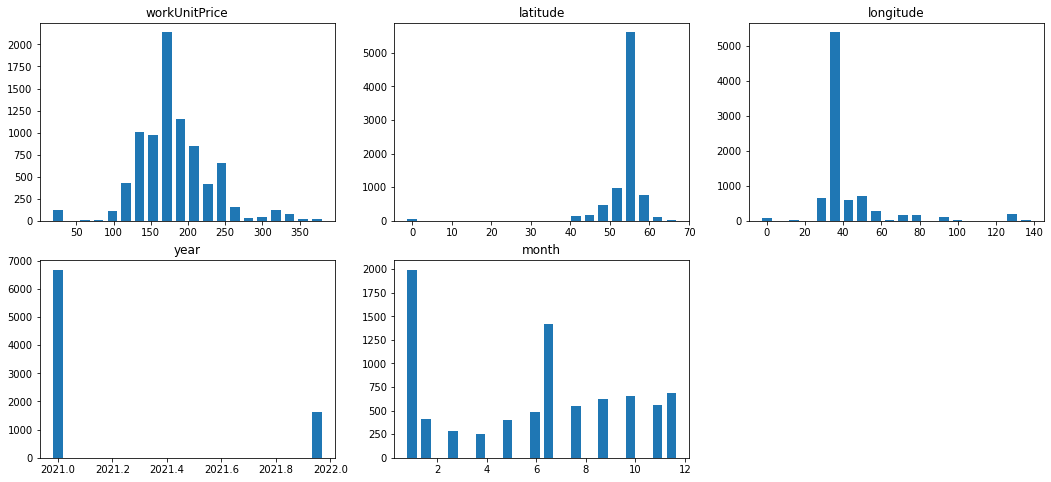

In [ ]:
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'workUnitPrice': df['workUnitPrice'].dropna(),
    'latitude': df['latitude'].dropna(),
    'longitude': df['longitude'].dropna(),
    'year': df['year'].dropna(),
    'month': df['month'].dropna()
})

In [ ]:
#df['workUnitPrice'].min()
#df['workUnitPrice'].max()

25.0

In [ ]:
!pip install pymorphy2
import pymorphy2
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import time

russian_stopwords = stopwords.words("russian")
lemma = pymorphy2.MorphAnalyzer()

#Код функции обработки текста:
def preprocess_text(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in russian_stopwords])
    punc_free = ''.join(ch for ch in stop_free if ch not in punctuation)
    text = " ".join([lemma.parse(word)[0].normal_form for word in punc_free.split(' ')])
    return text

df['lemmatized_description'] = df['description'].swifter.apply(preprocess_text)
df.head()

     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 8.2 MB 47.1 MB/s 


Pandas Apply:   0%|          | 0/8313 [00:00<?, ?it/s]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clientId,workUnit,workUnitPrice,workStartDate,latitude,longitude,name,...,month,city,district,territory,postal,region,proi2018,proi2019,proi2020,infl_kf
0,0,0,0,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.816065,37.458660,инженер-строительством,...,1,Москва,МО Покровское-Стрешнево,Центральный федеральный округ,125367.0,Москва,101.9,100.9,102.5,0.73
1,1,1,1,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.765458,37.796517,Электрик,...,1,Москва,МО Перово,Центральный федеральный округ,111123.0,Москва,101.9,100.9,102.5,0.73
2,2,2,2,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.685041,37.350683,Укладка пеноблоки с послойной (999) 890-55-38,...,1,Москва,МО Можайский,Центральный федеральный округ,143026.0,Москва,101.9,100.9,102.5,0.73
3,3,3,3,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.816065,37.458660,Руководил бригадой строителей,...,1,Москва,МО Покровское-Стрешнево,Центральный федеральный округ,125367.0,Москва,101.9,100.9,102.5,0.73
4,4,4,4,bf9bba14-1763-4aaf-ba33-32de6977d683,HOUR,100.0,2021-01-04,55.685041,37.350683,Геодезист,...,1,Москва,МО Можайский,Центральный федеральный округ,143026.0,Москва,101.9,100.9,102.5,0.73


In [ ]:
#df.to_csv('without_last_two_weeks.csv')

In [ ]:
russian_stopwords = stopwords.words("russian")

vectorizer = TfidfVectorizer(stop_words=russian_stopwords, token_pattern=u'(?ui)\\b\\w*[а-я]+\\w*\\b', ngram_range=(2,2))
matrix_tfidf = vectorizer.fit_transform(df['lemmatized_description'])

In [ ]:
top_words = pd.DataFrame(columns=df['specialityId'].unique())

def get_top_for_group(descriptions: pd.Series, group: str):
    global top_words
    if len(descriptions)<2 and len(descriptions.iloc[0].split())<2:
        return
    matrix_tfidf = vectorizer.fit_transform(descriptions)
    feature_array = np.array(vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(matrix_tfidf.toarray()).flatten()[::-1]

    n = 10
    top_n = feature_array[tfidf_sorting][:n]
    top_words[group] = pd.Series(top_n)

In [ ]:
for group in top_words.keys():
    descriptions = df[df['specialityId']==group]['lemmatized_description']
    get_top_for_group(descriptions, group)

top_words

,af02837b-7814-43d0-97ab-48b2b9813120,6c183c81-cdb8-4d9c-a48f-877a516a93bc,256464cf-39f5-405c-a006-6b1505f6a961,7ce33ae6-7b86-48e8-9698-7650b3cbe42e,889bf632-b7e6-4c9e-887d-fa06acc47f10,4f1a1b97-21c8-4f64-badf-ab4760eebaed,623c4e3e-5971-43f7-895a-c9e68abf9ede,122997d2-780f-4103-ac0a-4178dd479934,d55e4589-beac-4964-bd69-d7efff11290c,708435b6-3756-4edd-91a8-6275c55a5199,...,02aa72e5-25f4-4431-b9ae-c0e884b9eec3,b702d1bc-3bb8-4ef3-9cec-c5497bdd3c1b,7d225fcd-e2f4-4d4f-9b32-ccfe41d00338,2781a00b-692a-4e31-aee4-e38f40ba1204,0c0e3d17-3d22-458b-aad0-e6a578c091f8,fed91815-58de-49a1-ae0b-2f5deb32a6f3,643112d9-7adc-4017-87b4-f2c99c4c4ee4,2968c6b3-07f2-4f0c-b314-eabaf536d94d,2ce10ad8-3312-4c09-98ff-446824a9db8b,fbdb0f85-1254-4820-b656-09ec907d91ff
0,требование нормативный,электротехнический работа,цементный молоко,торговый зал,точный соответствие,товар торговый,товар мерчандайзинг,электронный площадка,товар предпродажный,товар мерчандайзинг,...,сборка букет,обработка заказ,центр дневный,час наш,система видеонаблюдение,яндекс тд,торговый зал,электроинструмент строительный,февраль время,NaN
1,соответствие выполнять,организация проведение,пеноблок механизировать,работник торговый,соответствие проект,торговый зал,подготовка товар,функционал электронный,предпродажный подготовка,подготовка товар,...,заказ день,заказ день,торговый центр,звонок час,работа система,нуля обеспечение,выкладка торговый,строительный работа,требование размер,NaN
2,работа требование,выполнение электротехнический,доставляться техника,управление бригада,работа обеспечивать,выкладка товар,товар предпродажный,услуга направить,товар мерчандайзинг,предпродажный подготовка,...,букет заказ,выкладка товар,проверка qrкод,наш сотрудник,накладный контроль,маркетплейс формирование,торговый зал,работа работа,размер нога,NaN
3,работа подрядный,выполнить работа,захватка ручной,товар прилавок,проект геометрический,этикетка скомпановать,предпродажный подготовка,поручение заказчик,подготовка товар,товар предпродажный,...,сборка букет,обработка заказ,дневный график,сотрудник обрабатывать,контроль накладный,маркетплейс яндекс,выкладка торговый,работа электроинструмент,примерка отбор,NaN
4,проектный документация,исполнительный документация,каждый смотреть,выкладка товар,обеспечивать точный,мир фототчёт,выкладка товар,оказать комплекс,выкладка товар,выкладка товар,...,заказ день,заказ день,qrкод торговый,обрабатывать звонок,контроль выходавход,маркировка контроль,NaN,слесарный работа,приглашать девушка,NaN
5,подрядный организация,контроль выполнение,куб оплата,бригада человек,комплекс геодезический,навешивание вещь,эп порядок,обязываться поручение,кассир постоянка,поддержание порядок,...,букет заказ,выкладка товар,центр дневный,рубль звонок,выходавход работа,наименование описание,NaN,технический осмотр,отбор февраль,NaN
6,организация контроль,объект контроль,м3 объём,торговый зал,геометрический параметр,наведение порядок,покупатель выставление,направить консультирование,кондитерский продукция,зал выкладка,...,сборка букет,обработка заказ,торговый центр,ь курировать,торговый зал,наполнение карточка,NaN,прибор запорный,отбор обувной,NaN
7,объём качество,организация выполнение,месяц старт,работник торговый,геодезический работа,мытьё полка,подсорт товар,консультирование клиент,набчелны ул,магазин модис,...,заказ день,заказ день,проверка qrкод,поддержка ь,охрана торговый,необходимый склад,NaN,арматура тд,обязательный требование,NaN
8,нормативный проектный,оформление технический,механизировать способ,управление бригада,выполнение комплекс,мытьё оборудование,поддержание порядок,комплекс услуга,молочный товар,мерчендайзинг поддержание,...,букет заказ,выкладка товар,дневный график,звонок загрузка,система видеонаблюдение,новый площадка,NaN,вентиляция пожаротушение,обувной коллекция,NaN
9,контроль соответствие,учёт выполнить,мм стоимость,товар прилавок,точный соответствие,мужчина постоянка,подготовкаработа тсд,клиент заказчик,молочный отдел,модис предпродажный,...,сборка букет,выкладка товар,qrкод торговы

In [ ]:
def count_words_from_top(description, top_words):
    tokens = nltk.word_tokenize(description)
    bigram = list(ngrams(tokens, 2)) 
    count = 0
    for token in bigram:
        if ' '.join(token) in list(top_words):
            count += 1
    return count

for speciality in df['specialityId'].unique():
    df[speciality] = df['lemmatized_description'].apply(count_words_from_top, args=(top_words[speciality],))

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8313 entries, 0 to 8312
Data columns (total 65 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            8313 non-null   int64         
 1   Unnamed: 0.1                          8313 non-null   int64         
 2   Unnamed: 0.1.1                        8313 non-null   int64         
 3   clientId                              8313 non-null   object        
 4   workUnit                              8313 non-null   object        
 5   workUnitPrice                         8313 non-null   float64       
 6   workStartDate                         8313 non-null   datetime64[ns]
 7   latitude                              8313 non-null   float64       
 8   longitude                             8313 non-null   float64       
 9   name                                  8313 non-null   object        
 10  

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8313 entries, 0 to 8312
Data columns (total 65 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            8313 non-null   int64         
 1   Unnamed: 0.1                          8313 non-null   int64         
 2   Unnamed: 0.1.1                        8313 non-null   int64         
 3   clientId                              8313 non-null   object        
 4   workUnit                              8313 non-null   object        
 5   workUnitPrice                         8313 non-null   float64       
 6   workStartDate                         8313 non-null   datetime64[ns]
 7   latitude                              8313 non-null   float64       
 8   longitude                             8313 non-null   float64       
 9   name                                  8313 non-null   object        
 10  

In [ ]:
df['02aa72e5-25f4-4431-b9ae-c0e884b9eec3'].value_counts()

0    8304
3       5
1       4
Name: 02aa72e5-25f4-4431-b9ae-c0e884b9eec3, dtype: int64

In [ ]:
columns = list(df['specialityId'].unique())+['year', 'month', 'latitude', 'longitude', 'infl_kf', 'proi2018', 'proi2019', 'proi2020']
X = df[columns]
y = df['workUnitPrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
#y_pred_s = pd.Series(y_pred)
#df_s = pd.concat([y_test, X_test], axis=1)

#df_s = df_s.merge(y_pred_s.rename('y_pred'), left_index=True, right_index=True)

In [ ]:
#df_s.to_csv('predict.csv')

In [ ]:
!pip3 install catboost
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostRegressor
RANDOM_SEED = 42
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric='R2',
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         plot=True
         )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
skl_wine_imp = model.get_feature_importance(prettified=True)


#plt.bar(skl_wine_imp['Feature Id'], skl_wine_imp['Importances'])

In [ ]:
skl_wine_imp

,Feature Id,Importances
0,infl_kf,12.504131
1,01de4e66-5d0f-49f9-bddc-1f708c87a6d6,8.714877
2,longitude,8.357304
3,latitude,7.911389
4,proi2020,6.505990
5,db7a9156-36ae-408a-a5df-955ab8738b57,5.988157
6,month,5.305545
7,7ce33ae6-7b86-48e8-9698-7650b3cbe42e,4.474590
8,proi2019,3.860455
9,proi2018,3.110831


In [ ]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.8317790685174554

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

0.0719776591183329

In [ ]:
m = CatBoostRegressor()

In [ ]:
params = {'iterations': [500, 1000, 5000, 100],
          'max_depth': [4, 6, 10],
          #'loss_function': ['RMSE', 'MultiRMSE', 'SurvivalAft', 'MAE', 'Quantile', 'LogLinQuantile', 'Poisson', 'MAPE'],
          #'l2_leaf_reg': np.logspace(-20, -19, 3),
          #'leaf_estimation_iterations': [10],
          #'eval_metric': ['MAPE'],
          #'use_best_model': ['True'],
          #'logging_level':['Silent'],
          'random_seed': [42, 50]
         }
cb = GridSearchCV(m, params,  scoring='r2')
cb.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
0:	learn: 48.2533117	total: 12.1ms	remaining: 1m
1:	learn: 47.9505809	total: 24.3ms	remaining: 1m
2:	learn: 47.6798067	total: 36.2ms	remaining: 1m
3:	learn: 47.4143793	total: 48.1ms	remaining: 1m
4:	learn: 47.1605942	total: 66.8ms	remaining: 1m 6s
5:	learn: 46.9289780	total: 81.2ms	remaining: 1m 7s
6:	learn: 46.6775086	total: 93ms	remaining: 1m 6s
7:	learn: 46.4173331	total: 105ms	remaining: 1m 5s
8:	learn: 46.1469510	total: 117ms	remaining: 1m 4s
9:	learn: 45.9011460	total: 128ms	remaining: 1m 4s
10:	learn: 45.6591065	total: 140ms	remaining: 1m 3s
11:	learn: 45.4622560	total: 156ms	remaining: 1m 4s
12:	learn: 45.2686774	total: 168ms	remaining: 1m 4s
13:	learn: 45.0672761	total: 180ms	remaining: 1m 3s
14:	learn: 44.8144626	total: 192ms	remaining: 1m 3s
15:	learn: 44.6277373	total: 204ms	remaining: 1m 3s
16:	learn: 44.4605114	total: 216ms	remaining: 1m 3s
17:	learn: 44.2334715	total: 228ms	remaining: 1m 3s
18:	learn: 44

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x7fd950c46410>,
             param_grid={'iterations': [500, 1000, 5000, 100],
                         'max_depth': [4, 6, 10], 'random_seed': [42, 50]},
             scoring='r2')

In [ ]:
best_param = cb.best_params_
best_param

{'iterations': 5000, 'max_depth': 10, 'random_seed': 42}

In [ ]:
y_pred = cb.best_estimator_.predict(X_test)
r2_score(y_test, y_pred)

0.8435942842481177

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

0.06529747750387568

# Prediction for test file19042022

In [ ]:
data_prod = pd.read_csv('testdata1904koefz.csv', sep=',', parse_dates=['workStartDate'])
data_prod.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clientId,orderId,orderManagerId,objectId,priceListId,name,industry,...,territory,postal,region,year,day,month,infl_kf,proi2018,proi2019,proi2020
0,0,0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,NaN,...,Центральный федеральный округ,141420.0,Московская область,2022,4,4,NaN,"102,6","104,1","99,3"
1,1,1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,NaN,...,Приволжский федеральный округ,460000.0,Оренбургская область,2022,4,4,NaN,"102,8",106,"104,5"
2,2,2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,NaN,...,Центральный федеральный округ,105043.0,Москва,2022,3,3,8.39,"101,9","100,9","102,5"
3,3,3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,NaN,...,Приволжский федеральный округ,450022.0,Республика Башкортостан,2022,4,4,NaN,"104,7","104,9","98,1"
4,4,4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,NaN,...,Северо-Западный федеральный округ,183050.0,Мурманская область,2022,4,4,NaN,"101,6","106,1","114,5"


In [ ]:
data_prod.dtypes

Unnamed: 0          int64
Unnamed: 0.1        int64
Unnamed: 0.1.1      int64
clientId           object
orderId            object
                   ...   
month               int64
infl_kf           float64
proi2018           object
proi2019           object
proi2020           object
Length: 114, dtype: object

In [ ]:
data_prod['proi2018'] = [x.replace(',', '.') for x in data_prod['proi2018']]
data_prod['proi2019'] = [x.replace(',', '.') for x in data_prod['proi2019']]
data_prod['proi2020'] = [x.replace(',', '.') for x in data_prod['proi2020']]

In [ ]:
data_prod = data_prod.astype({"proi2018": float, "proi2019": float, "proi2020": float}, errors='ignore')

In [ ]:
data_prod['infl_kf'].mean()

8.389999999999993

In [ ]:
data_prod['infl_kf'] = data_prod['infl_kf'].fillna(8.39)
data_prod['infl_kf'].isnull().sum()

0

In [ ]:
data_prod['year'] = data_prod['workStartDate'].dt.year
data_prod['month'] = data_prod['workStartDate'].dt.month

In [ ]:
data_prod

In [ ]:
IQR1 = 24.5
IQR2 = 412.5

In [ ]:
#y25 = data_prod['workUnitPrice'].quantile(q=0.25)
#y75 = data_prod['workUnitPrice'].quantile(q=0.75)
#IQR1 = y25 - 1.5*(y75-y25)
#IQR2 = y75 + 1.5*(y75-y25)

In [ ]:
data_prod = data_prod[(data_prod['workUnitPrice']>IQR1) & (data_prod['workUnitPrice']<IQR2)]

In [ ]:
#data_prod['publicationDate'] = pd.to_datetime(data_prod['publicationDate'], dayfirst=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#data_prod['publicationDate']=pd.to_datetime(data_prod['publicationDate']).dt.strftime('%Y-%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


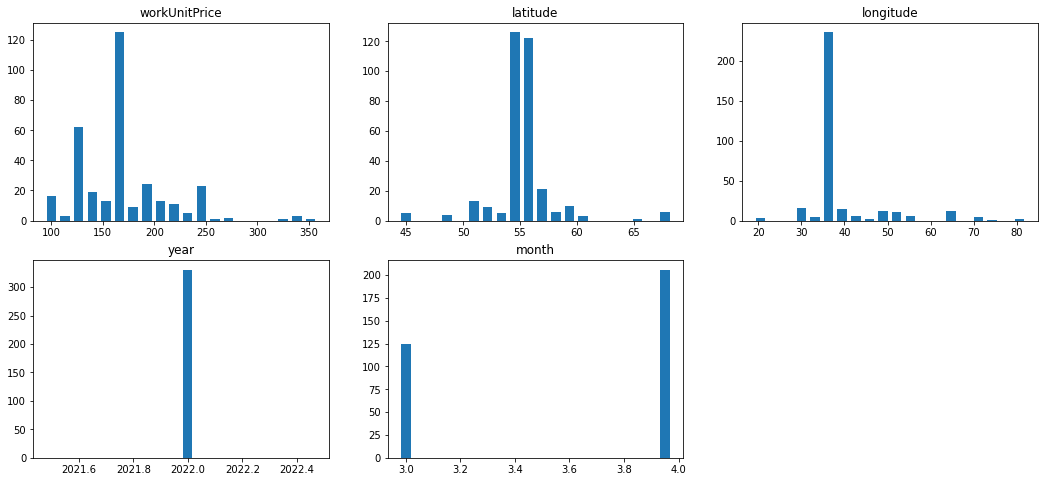

In [ ]:
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'workUnitPrice': data_prod['workUnitPrice'].dropna(),
    'latitude': data_prod['latitude'].dropna(),
    'longitude': data_prod['longitude'].dropna(),
    'year': data_prod['year'].dropna(),
    'month': data_prod['month'].dropna()
})

In [ ]:
data_prod['lemmatized_description'] = data_prod['description'].swifter.apply(preprocess_text)
data_prod.head()

Pandas Apply:   0%|          | 0/331 [00:00<?, ?it/s]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clientId,orderId,orderManagerId,objectId,priceListId,name,industry,...,postal,region,year,day,month,infl_kf,proi2018,proi2019,proi2020,lemmatized_description
0,0,0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,NaN,...,141420.0,Московская область,2022,4,4,8.39,102.6,104.1,99.3,выкладка товар
1,1,1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,NaN,...,460000.0,Оренбургская область,2022,4,4,8.39,102.8,106.0,104.5,проверка соответствие наличие ценник пополнени...
2,2,2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,NaN,...,105043.0,Москва,2022,3,3,8.39,101.9,100.9,102.5,выкладка товар прилавок
3,3,3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,NaN,...,450022.0,Республика Башкортостан,2022,4,4,8.39,104.7,104.9,98.1,проверка соответствие наличие ценник пополнени...
4,4,4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,NaN,...,183050.0,Мурманская область,2022,4,4,8.39,101.6,106.1,114.5,осуществить погрузка разгрузка товар


In [ ]:
for speciality in top_words.keys():
    data_prod[speciality] = data_prod['lemmatized_description'].apply(count_words_from_top, args=(top_words[speciality],))

data_prod.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,clientId,orderId,orderManagerId,objectId,priceListId,name,industry,...,02aa72e5-25f4-4431-b9ae-c0e884b9eec3,b702d1bc-3bb8-4ef3-9cec-c5497bdd3c1b,7d225fcd-e2f4-4d4f-9b32-ccfe41d00338,2781a00b-692a-4e31-aee4-e38f40ba1204,0c0e3d17-3d22-458b-aad0-e6a578c091f8,fed91815-58de-49a1-ae0b-2f5deb32a6f3,643112d9-7adc-4017-87b4-f2c99c4c4ee4,2968c6b3-07f2-4f0c-b314-eabaf536d94d,2ce10ad8-3312-4c09-98ff-446824a9db8b,fbdb0f85-1254-4820-b656-09ec907d91ff
0,0,0,5821,8aeee516-fe8b-41cc-8a84-1005982fd998,9f2fcf5e-5e71-49a9-9cbd-b55f9bb78718,59cffbdd-fb52-448d-8ce0-d0b33370a03c,6f4621aa-90a3-4088-804c-84aead1d1873,NaN,выкладка товара,NaN,...,0,1,0,0,0,0,0,0,0,0
1,1,1,5845,e09cb55f-b62d-4acc-8647-6a65ec5ea937,794cb0f9-e49e-48c3-81d6-58abeff06df0,9faaf16f-7a4c-4c0c-ae36-a93086e735d9,e851dfce-f649-465f-8650-b7bc9544035a,NaN,Zenden. Мерчандайзинг.,NaN,...,0,0,0,0,2,0,2,0,0,0
2,2,2,5882,ba5f2689-87df-483c-a115-942e1abf130a,9b507ef8-1a60-43dd-aeba-6b5b5e1a4cd6,c475ac8c-c7c5-4368-a4d4-dd11d0b11c88,6b2a2d79-6177-4234-9d50-f7c03b95c24c,NaN,Работник торгового зала,NaN,...,0,1,0,0,0,0,0,0,0,0
3,3,3,5963,e09cb55f-b62d-4acc-8647-6a65ec5ea937,422db170-ced4-4991-a517-7102c58fa99a,f1056f8a-c08e-4fc6-992d-c5f22b9e5191,0670a2f7-531c-44da-ae97-b194266d1eed,NaN,Zenden. Мерчандайзинг.,NaN,...,0,0,0,0,2,0,2,0,0,0
4,4,4,5964,c9597816-a374-41dc-be3e-b052b25c5582,bf7f0d13-1e44-43fc-9608-d9d6719853cb,9f66e9d8-3065-4af3-90bd-72d9a3809a04,44d948d4-6a65-482f-9ffa-bc0480e519e6,NaN,Zenden. Погрузо-разгрузочные работы.,NaN,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
columns = list(df['specialityId'].unique())+['year', 'month', 'latitude', 'longitude', 'infl_kf', 'proi2018', 'proi2019', 'proi2020']
X = data_prod[columns]
y = data_prod['workUnitPrice']

In [ ]:
y_pred = model.predict(X)
r2_score(y, y_pred)

0.6254008229788599

In [ ]:
mean_absolute_percentage_error(y, y_pred)

0.06742474905019101

In [ ]:
y_pred = cb.best_estimator_.predict(X)
r2_score(y, y_pred)

0.6043378167673157

In [ ]:
mean_absolute_percentage_error(y, y_pred)

0.057987407940119896